# Dissatified Customers Detection using `XGBoost` classification model

#### Julia Nguyen
----

Data source: https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2017/06/19/guide-to-ibm-cognos-analytics-sample-data-sets

1. [Import and Understand data](#download-the-data)
2. [Data Prep](#data-cleaning)
    - Handle missing data
    - Converting columns into appropriate data types
3. [Build preliminary model](#build-model)
    - One-Hot-Encoding
4. [Optimize parameters](#optimize)
5. [Identify most important features](#shap)

In [98]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, classification_report

<a id="download-the-data"></a>
## 1. Load and understand dataset

In [79]:
df = pd.read_csv('customer_satisfaction.csv')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

<a id="data-cleaning"></a>
## 2. Data Cleaning

CustomerID, Count and the last 4 variables do not add values to our model so we will remove them. We will also remove Lat Long in favor of Latitude and Longtitude columns

In [80]:
df.drop(['CustomerID', 'Count', 'Churn Label', 'Churn Score', 'CLTV', 'Churn Reason', 'Lat Long'], axis=1, inplace=True)

In [20]:
df['Country'].value_counts()

United States    7043
Name: Country, dtype: int64

In [21]:
df['State'].value_counts()

California    7043
Name: State, dtype: int64

In [22]:
df['City'].value_counts()

Los Angeles       305
San Diego         150
San Jose          112
Sacramento        108
San Francisco     104
                 ... 
Healdsburg          4
Jenner              4
Philo               4
Point Arena         4
Olympic Valley      4
Name: City, Length: 1129, dtype: int64

We will remove Country and State since these columns contain only 1 value and we will replace the space in city  names with '_' 

In [81]:
df.drop(['Country', 'State'], axis=1, inplace=True)

In [82]:
df['City'].replace(' ', '_', regex=True, inplace=True)
df['City'].head()

0    Los_Angeles
1    Los_Angeles
2    Los_Angeles
3    Los_Angeles
4    Los_Angeles
Name: City, dtype: object

In [48]:
## Check for duplicate

df.duplicated().any()

False

In [49]:
## Check for null values

df.isnull().sum()

Count                0
City                 0
Zip Code             0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Label          0
dtype: int64

#### Handle missing values

While there is no null values in the dataset, the Total Charges object datatype suggests that it contains more than just numbers. This is confirmed by a value error when converting it into numeric type.

There must be blank space in total charges so let's check to see how many of these. If there a not a lot, we can replace them with `0`.

In [83]:
len(df[df['Total Charges']==' '])

11

In [84]:
df.loc[df['Total Charges']==' ']

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [85]:
df['Total Charges'].replace(' ', 0, inplace=True)

In [86]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'])

<a id="build-model"></a>
## 3. Build model

In [87]:
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']

In [88]:
X.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30


In [89]:
y.unique()

array([1, 0], dtype=int64)

#### One-hot Encoding

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Count              7043 non-null   int64  
 1   City               7043 non-null   object 
 2   Zip Code           7043 non-null   int64  
 3   Latitude           7043 non-null   float64
 4   Longitude          7043 non-null   float64
 5   Gender             7043 non-null   object 
 6   Senior Citizen     7043 non-null   object 
 7   Partner            7043 non-null   object 
 8   Dependents         7043 non-null   object 
 9   Tenure Months      7043 non-null   int64  
 10  Phone Service      7043 non-null   object 
 11  Multiple Lines     7043 non-null   object 
 12  Internet Service   7043 non-null   object 
 13  Online Security    7043 non-null   object 
 14  Online Backup      7043 non-null   object 
 15  Device Protection  7043 non-null   object 
 16  Tech Support       7043 

In [67]:
X.columns

Index(['Count', 'City', 'Zip Code', 'Latitude', 'Longitude', 'Gender',
       'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges'],
      dtype='object')

In [90]:
X = pd.get_dummies(X, columns=['City', 'Gender',
       'Senior Citizen', 'Partner', 'Dependents', 
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method'])

In [91]:
X.head()

,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


#### Splitting data

In [92]:
# Let's check for class balance

sum(y)/len(y)

0.2653698707936959

So we see that only 27% are unhappy. Because of this, we will split training and testing data using stratification in order to maintain the same percentage.

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)

In [94]:
sum(y_test)/len(y_test)

0.26519023282226006

#### Preliminary model

In [110]:
import xgboost as xgb

model = xgb.XGBClassifier(objective='binary:logistic', missing=0, seed=42, eval_metric='aucpr', early_stopping_rounds=10)

model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.67671
[1]	validation_0-aucpr:0.69837
[2]	validation_0-aucpr:0.70375
[3]	validation_0-aucpr:0.70749
[4]	validation_0-aucpr:0.70881
[5]	validation_0-aucpr:0.70180
[6]	validation_0-aucpr:0.70090
[7]	validation_0-aucpr:0.70457
[8]	validation_0-aucpr:0.70324
[9]	validation_0-aucpr:0.70209
[10]	validation_0-aucpr:0.69987
[11]	validation_0-aucpr:0.69793
[12]	validation_0-aucpr:0.69893
[13]	validation_0-aucpr:0.70012


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Let's see how it performs on the Testing Dataset and drawing a Confusion Matrix.

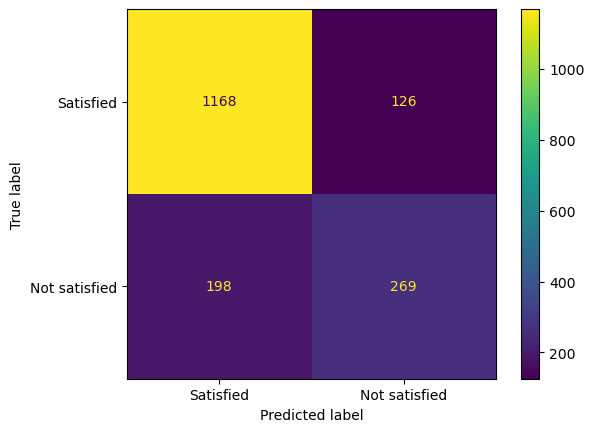

In [111]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, values_format='d', display_labels=['Satisfied', 'Not satisfied'])

In [118]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1294
           1       0.68      0.58      0.62       467

    accuracy                           0.82      1761
   macro avg       0.77      0.74      0.75      1761
weighted avg       0.81      0.82      0.81      1761



We saw that while 90% satisfied customers were correctly classified, only 58% unsatisfied customers were correctly classified. Because we want to recover poor customer experience and retain customers, we would like to have more accuracy in capturing unhappy customers and therefore recall is a more important metric. 

<a id="optimize"></a>
## Optimize Parameters using GridSearch

We will use **XGBoost parameter** `scale_pos_weight` to handle imbalanced data

In [101]:
param_grid = {'max_depth':[3, 4, 5],
              'learning_rate':[0.1, 0.01, 0.05],
              'gamma':[0, 0.25, 1.0],
              'reg_lambda':[0, 1.0, 10.0],
              'scale_pos_weight':[1, 3, 5]} # XGBoost recommends sum(negative instances) / sum(positive instances)

model1 = GridSearchCV(xgb, param_grid=param_grid, scoring='roc_auc', n_jobs=10, cv=3)

In [106]:
#model1.estimator.set_params(**{"eval_metric":"auc", "early_stopping_rounds":10})

model1.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


[0]	validation_0-auc:0.84799
[1]	validation_0-auc:0.84716
[2]	validation_0-auc:0.85260
[3]	validation_0-auc:0.85586
[4]	validation_0-auc:0.85649
[5]	validation_0-auc:0.86047
[6]	validation_0-auc:0.86171
[7]	validation_0-auc:0.86436
[8]	validation_0-auc:0.86627
[9]	validation_0-auc:0.86693
[10]	validation_0-auc:0.86713
[11]	validation_0-auc:0.86798
[12]	validation_0-auc:0.86853
[13]	validation_0-auc:0.86954
[14]	validation_0-auc:0.86930
[15]	validation_0-auc:0.86998
[16]	validation_0-auc:0.87055
[17]	validation_0-auc:0.87044
[18]	validation_0-auc:0.87056
[19]	validation_0-auc:0.87087
[20]	validation_0-auc:0.87074
[21]	validation_0-auc:0.87081
[22]	validation_0-auc:0.87098
[23]	validation_0-auc:0.87083
[24]	validation_0-auc:0.87067
[25]	validation_0-auc:0.87081
[26]	validation_0-auc:0.87076
[27]	validation_0-auc:0.87091
[28]	validation_0-auc:0.87094
[29]	validation_0-auc:0.87044
[30]	validation_0-auc:0.87075
[31]	validation_0-auc:0.87073
[32]	validation_0-auc:0.87081


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=0, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc')

In [107]:
model1.best_params_

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 10.0,
 'scale_pos_weight': 3}

In [108]:
model1.best_score_

0.8598739827634989

In [113]:
optimal_model = xgb.XGBClassifier(seed=42,
                            missing=0,
                            objective='binary:logistic',
                            gamma=0.25,
                            learning_rate=0.1,
                            max_depth=4,
                            reg_lambda=10,
                            scale_pos_weight=3,
                            early_stopping_rounds=10,
                            eval_metric='aucpr')

optimal_model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.63792
[1]	validation_0-aucpr:0.64000
[2]	validation_0-aucpr:0.64491
[3]	validation_0-aucpr:0.65061
[4]	validation_0-aucpr:0.65203
[5]	validation_0-aucpr:0.66539
[6]	validation_0-aucpr:0.66946
[7]	validation_0-aucpr:0.67401
[8]	validation_0-aucpr:0.69734
[9]	validation_0-aucpr:0.69243
[10]	validation_0-aucpr:0.69303
[11]	validation_0-aucpr:0.69655
[12]	validation_0-aucpr:0.69717
[13]	validation_0-aucpr:0.69870
[14]	validation_0-aucpr:0.69812
[15]	validation_0-aucpr:0.70162
[16]	validation_0-aucpr:0.70156
[17]	validation_0-aucpr:0.70354
[18]	validation_0-aucpr:0.70282
[19]	validation_0-aucpr:0.70349
[20]	validation_0-aucpr:0.70327
[21]	validation_0-aucpr:0.70463
[22]	validation_0-aucpr:0.70391
[23]	validation_0-aucpr:0.70285
[24]	validation_0-aucpr:0.70009
[25]	validation_0-aucpr:0.70016
[26]	validation_0-aucpr:0.69932
[27]	validation_0-aucpr:0.70210
[28]	validation_0-aucpr:0.70117
[29]	validation_0-aucpr:0.70088
[30]	validation_0-aucpr:0.70103


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [119]:
print(classification_report(y_test, optimal_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1294
           1       0.53      0.85      0.65       467

    accuracy                           0.76      1761
   macro avg       0.73      0.79      0.73      1761
weighted avg       0.82      0.76      0.77      1761



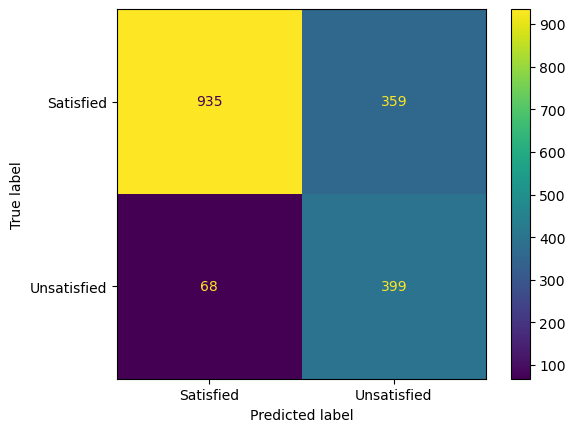

In [121]:
ConfusionMatrixDisplay.from_estimator(optimal_model,
                                      X_test,
                                      y_test,
                                      values_format='d',
                                      display_labels=["Satisfied", "Unsatisfied"])

We see that the optimized XGBoost model is a lot better at identifying customers that are not satisfied. Of the 467 unsatisfied customers, **399 (85%)**, were correctly identified. Before optimization, we only correctly identified 269 (58%). However, this improvement was at the expense of not being able to correctly classify as many people that are satisfied. Before optimization, we correctly identified **1,168 (90%)** people that did not leave. Now we only correctly classify **935 (72%)** That said, this trade off may be better for the company because now it can focus resources on the customers that are not satisfied to help retain them.

#### Plot a tree graph

In [125]:
bst = optimal_model.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', ## make the nodes fancy
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

graph = xgb.to_graphviz(optimal_model, num_trees=0, 
                condition_node_params=node_params,
                leaf_node_params=leaf_params) 

weight:  {'Zip Code': 35.0, 'Latitude': 18.0, 'Longitude': 18.0, 'Tenure Months': 65.0, 'Monthly Charges': 52.0, 'Total Charges': 25.0, 'City_Bakersfield': 1.0, 'City_Cupertino': 7.0, 'City_Oakland': 1.0, 'City_Running_Springs': 2.0, 'City_San_Francisco': 1.0, 'City_San_Jose': 1.0, 'City_Santa_Clara': 1.0, 'Gender_Female': 1.0, 'Senior Citizen_No': 1.0, 'Partner_No': 4.0, 'Dependents_No': 46.0, 'Phone Service_No': 5.0, 'Multiple Lines_No': 6.0, 'Internet Service_DSL': 2.0, 'Internet Service_Fiber optic': 10.0, 'Online Security_No': 15.0, 'Online Security_Yes': 1.0, 'Online Backup_No': 7.0, 'Tech Support_No': 9.0, 'Streaming TV_Yes': 4.0, 'Streaming Movies_Yes': 7.0, 'Contract_Month-to-month': 19.0, 'Contract_One year': 8.0, 'Contract_Two year': 7.0, 'Paperless Billing_No': 19.0, 'Payment Method_Electronic check': 17.0, 'Payment Method_Mailed check': 2.0}
gain:  {'Zip Code': 13.805845260620117, 'Latitude': 7.507357120513916, 'Longitude': 5.979390621185303, 'Tenure Months': 33.0781440734

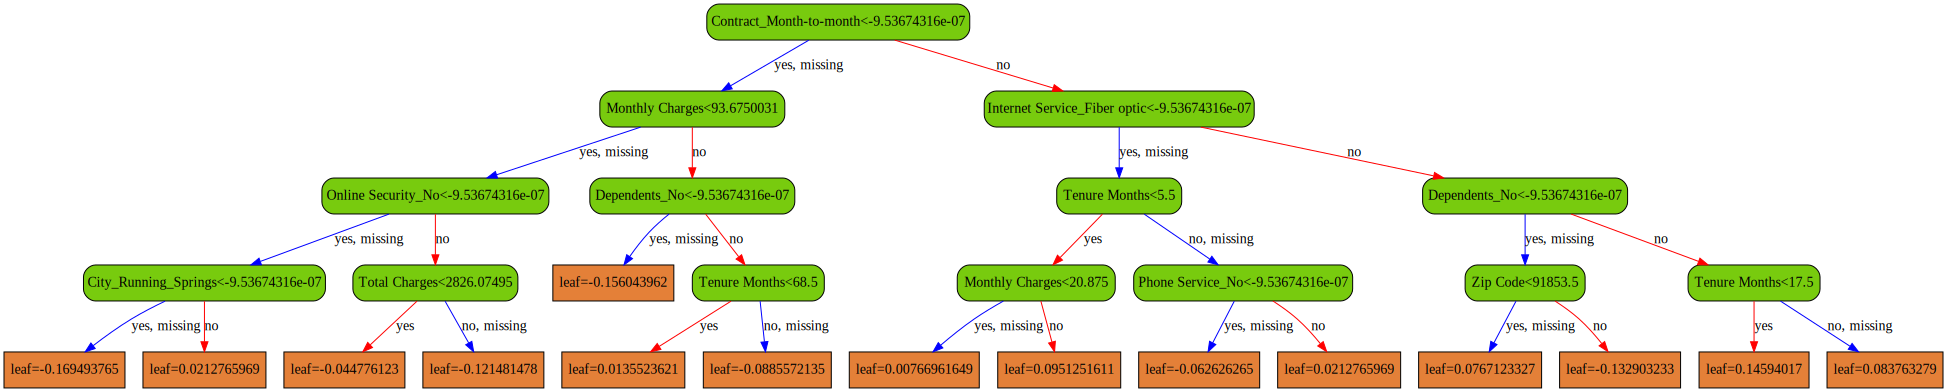

In [127]:
graph

In [126]:
graph.render('output.pdf', format='pdf')

'output.pdf.pdf'

<a id="shap"></a>
## 5. Identifying most important features

Let's draw SHAP plot to show which features are most important for the model

In [129]:
import shap

In [131]:
explainer = shap.Explainer(optimal_model)
shap_values = explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


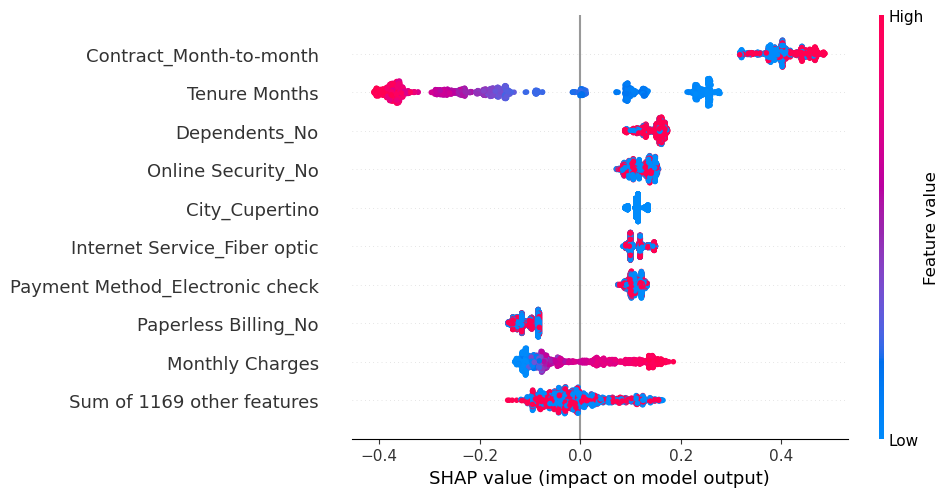

In [132]:
shap.plots.beeswarm(shap_values)